In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.sql.functions import corr


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("ReadCSV").getOrCreate()

# Read the CSV file into a DataFrame
df = spark.read.csv("ML_hw_dataset.csv", header=True, inferSchema=True)

df.printSchema()
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/24 00:44:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)

+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+-----

In [3]:
df.dropna(how='any', thresh=None, subset=None)
df.show()

+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no| cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician| married|          unknown|     no|     no|  no| cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|      

In [4]:
# select categorical columns
categorical_cols = [ 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
# index all categorical columns
for column in categorical_cols:
  indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
  df = indexer.fit(df).transform(df)
    
# Drop the original categorical column and rename the encoded column
for column in categorical_cols:
  df = df.drop(column).withColumnRenamed(column+"_index", column)

# Show the result
df.show()
df.printSchema()


+---+-----------+-----+-----------+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+-------+---------+-------+-------+----+-------+--------+
|age|        job|month|day_of_week|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|marital|education|default|housing|loan|contact|poutcome|
+---+-----------+-----+-----------+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+-------+---------+-------+-------+----+-------+--------+
| 44|blue-collar|  aug|        thu|     210|       1|  999|       0|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|    0.0|      4.0|    1.0|    0.0| 0.0|    0.0|     0.0|
| 53| technician|  nov|        fri|     138|       1|  999|       0|        -0.1|          93.2|        -42.0|    4.021|     5195.8|  0|    0.0|      6.0|    0.0|    1.0| 0.0|    0.0|     0.0|
| 28| management|  jun|        thu|

In [5]:
selected_cols=['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome','age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','y']
# Calculate the correlation matrix using the corr() function
corr_matrix = df.select(selected_cols).toPandas().corr()

# Print the correlation matrix
print(corr_matrix)

                 marital  education   default   housing      loan   contact  \
marital         1.000000  -0.104975 -0.103930 -0.003643  0.001719 -0.043564   
education      -0.104975   1.000000  0.196636  0.015171 -0.005054  0.089817   
default        -0.103930   0.196636  1.000000  0.017586  0.000970  0.135238   
housing        -0.003643   0.015171  0.017586  1.000000  0.234192  0.083498   
loan            0.001719  -0.005054  0.000970  0.234192  1.000000  0.004391   
contact        -0.043564   0.089817  0.135238  0.083498  0.004391  1.000000   
poutcome        0.030627  -0.025132 -0.108159 -0.021599 -0.000581 -0.226813   
age            -0.114983   0.182827  0.164965  0.000987 -0.006397  0.007021   
duration        0.001220   0.010369 -0.011794  0.004850 -0.003194 -0.026657   
campaign        0.002269   0.002767  0.032825  0.009768  0.003899  0.077368   
pdays          -0.017635   0.018061  0.080062  0.010376  0.001298  0.117970   
previous        0.030222  -0.022295 -0.102416 -0.017

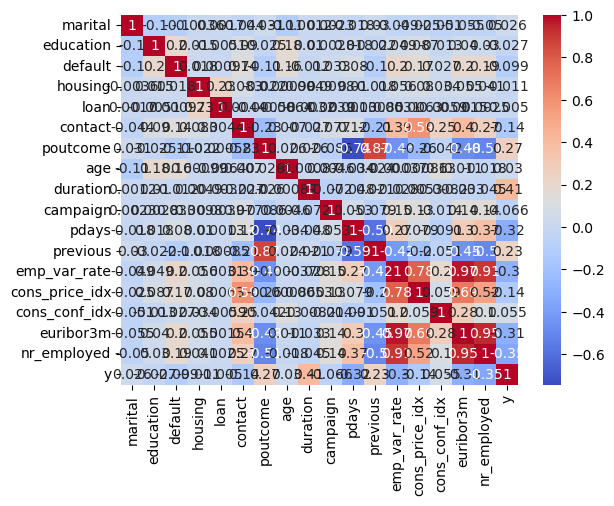

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create heatmap with colorbar
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
# Show plot
plt.show()

In [7]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
inputCol=["euribor3m", "nr_employed", "emp_var_rate"]
assembler = VectorAssembler(inputCols =["euribor3m", "nr_employed", "emp_var_rate","duration","pdays","emp_var_rate"], outputCol='features')

output = assembler.transform(df)

finalised_data = output.select('features', 'y')
finalised_data = finalised_data.withColumnRenamed("y", "label")
# print(str(train.count()),str(test.count()))
# lr = LogisticRegression(featuresCol='features',labelCol="y",maxIter=5)
# lrn = lr.fit(train)
# lrn_summary = lrn.summary
# lrn_summary.predictions.show()

In [8]:
# # Make predictions on the test data
# predictions = lrn.transform(test)

# # Select prediction and label columns for evaluation
# predictions = predictions.select(col("prediction"), col("y").alias("label"))

# # Evaluate the model's performance
# accuracy = predictions.filter(predictions.prediction == predictions.label).count() / float(test.count())

# print("Accuracy:", accuracy)

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

finalised_data.show()

(trainingData, testData) = finalised_data.randomSplit([0.7, 0.3])
print("train:",str(trainingData.count())," test:",str(testData.count()))

# Create a LinearSVC model
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model on the training data
model = lsvc.fit(trainingData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the performance of the model
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)
print("AUC", auc)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision =", precision)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall =", recall)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy =", accuracy)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.963,5228.1,1.4...|    0|
|[4.021,5195.8,-0....|    0|
|[0.729,4991.6,-1....|    1|
|[1.405,5099.1,-1....|    0|
|[0.869,5076.2,-2....|    1|
|[4.961,5228.1,1.4...|    0|
|[1.327,5099.1,-1....|    0|
|[1.313,5099.1,-1....|    0|
|[1.266,5076.2,-2....|    1|
|[1.41,5099.1,-1.8...|    0|
|[4.864,5191.0,1.1...|    0|
|[4.964,5228.1,1.4...|    0|
|[4.965,5228.1,1.4...|    1|
|[1.291,5099.1,-1....|    0|
|[4.96,5228.1,1.4,...|    0|
|[4.962,5228.1,1.4...|    0|
|[1.365,5099.1,-1....|    1|
|[4.86,5195.8,-0.1...|    1|
|[4.86,5191.0,1.1,...|    0|
|[4.96,5228.1,1.4,...|    0|
+--------------------+-----+
only showing top 20 rows



train: 28725  test: 12463


23/04/24 00:44:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/24 00:44:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


AUC 0.9188959643933945


Precision = 0.8779528145802518


Recall = 0.8966540961245286
accuracy = 0.8966540961245286


In [10]:
lr = LogisticRegression(featuresCol='features',labelCol="label",maxIter=5)
lrn = lr.fit(trainingData)
# Make predictions on the test data
predictions2 = lrn.transform(testData)

# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions2)
print("AUC", auc)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions2)
print("Precision =", precision)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions2)
print("Recall =", recall)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions2)
print("accuracy =", accuracy)


AUC 0.9207683539226
Precision = 0.8944740909204916


Recall = 0.9071652090186952
accuracy = 0.9071652090186954
